In [1]:
#!pip install rasterio

In [2]:
import os
import numpy as np
#from osgeo import gdal, gdal_array, ogr
import rasterio as rio
import pandas as pd
import pickle
import cubist
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import train_test_split
import multiprocessing as mp
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from joblib import Parallel, delayed

In [3]:
import import_ipynb 
from Header import *

importing Jupyter notebook from Header.ipynb


In [4]:
# Function to calculate first-order differences of spectra
def fod (spectra):
    fo_spec = spectra.iloc[:,:]
    (row,col) = fo_spec.shape
    
    for i in range(0, col):
        if i==col-1:
            fo_spec.iloc[:,i] = fo_spec.iloc[:,i-1]
        else:    
            fo_spec.iloc[:,i] = (spectra.iloc[:,i+1]- spectra.iloc[:,i])
    return fo_spec



def continuum_removal(points):
    x1, y1 = points.T
    augmented = np.concatenate([points, [(x1[0], np.min(y1)-1), (x1[-1], np.min(y1)-1)]], axis=0)
    hull = ConvexHull(augmented)
    continuum_points = points[np.sort([v for v in hull.vertices if v < len(points)])]
    continuum_function = interp1d(*continuum_points.T)
    yprime = continuum_function(x1) - y1
    #yprime = y1 / continuum_function(x1)

    return yprime


def continuum_removed_fast(spectra):
    def process_each_row(y1):
        points = np.vstack([np.arange(len(y1)), y1]).T
        yprime = continuum_removal(points)
        #print('one more row done..')
        return yprime

    cr_spec_values = Parallel(n_jobs=-1)(delayed(process_each_row)(row) for row in spectra.values)

    cr_spec = spectra.copy()
    cr_spec.iloc[:, :] = np.array(cr_spec_values)

    return cr_spec

# Worker function for parallel predictions
def worker(arr):
    return model.predict(arr)

# Function to make parallel predictions
def make_parallel_predictions(model, X):
    num_processes = mp.cpu_count()
    chunk_size = int(X.shape[0] / num_processes)
    chunks = [X[i:i + chunk_size] for i in range(0, X.shape[0], chunk_size)]

    with mp.Pool(processes=num_processes) as pool:
        results = pool.map(worker, chunks)

    y_pred = np.concatenate(results, axis=0)
    return y_pred

### Reading satelite image and Imputing NaN values 

In [5]:
fname = 'IsraelS22.tif'

src = rio.open(fname)
metadata = src.meta
num_bands = src.count
print('image opened in src')

height=0
width=0
image = []

for i in range(num_bands):
    layer = src.read(i+1)
    print('read layer no..', i)
    layer = layer.astype('float32')
    layer = layer[::10, ::10]
    print(layer.shape)
    height, width = layer.shape
    #image[image < 0] = np.nan
    #layer = layer / 1000
    #layer[layer < 0] = np.nan
    #print('invalid marked as NaN complete..')
    image.append(layer.flatten())
    print('Flatening complete..')
    # has_nan = np.isnan(image).sum()
    # print('has_nan:', has_nan)


image = np.array(image).T    
print('image available as array..')  

print('height:', height, 'width:', width )

image opened in src
read layer no.. 0
(803, 526)
Flatening complete..
read layer no.. 1
(803, 526)
Flatening complete..
read layer no.. 2
(803, 526)
Flatening complete..
read layer no.. 3
(803, 526)
Flatening complete..
read layer no.. 4
(803, 526)
Flatening complete..
read layer no.. 5
(803, 526)
Flatening complete..
read layer no.. 6
(803, 526)
Flatening complete..
read layer no.. 7
(803, 526)
Flatening complete..
read layer no.. 8
(803, 526)
Flatening complete..
read layer no.. 9
(803, 526)
Flatening complete..
image available as array..
height: 803 width: 526


In [6]:
src.read(1).shape

(8028, 5258)

In [7]:
image_df = pd.DataFrame(image)
image_df.columns = ['493', '560', '665', '704', '741', '783', '833', '865', '1614', '2202']
print('image ready as data frame ... with columns named..')

image ready as data frame ... with columns named..


In [8]:
bool_nan_rows= image_df.isna().any(axis=1)
image_df[bool_nan_rows].head(5)

,493,560,665,704,741,783,833,865,1614,2202
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
#image_df.drop('619', axis=1, inplace=True)
print('NaN value imputation started....')
image_df_nonan = image_df.ffill().bfill()
print('NaN value imputation complete....')
#image_df = image_df_nonan.copy()

NaN value imputation started....
NaN value imputation complete....


In [10]:
# Load your data into a DataFrame (assuming df is your DataFrame)
nan_summary = image_df_nonan.isna().sum()
print(nan_summary)

493     0
560     0
665     0
704     0
741     0
783     0
833     0
865     0
1614    0
2202    0
dtype: int64


### Create all processed (Spectral) Data

In [11]:
#prepare_spec = ['none', 'cr', 'log', 'fod', 'fod_cr', 'fod_log']
spectra = image_df_nonan.copy()
spectra = spectra.astype('float32')

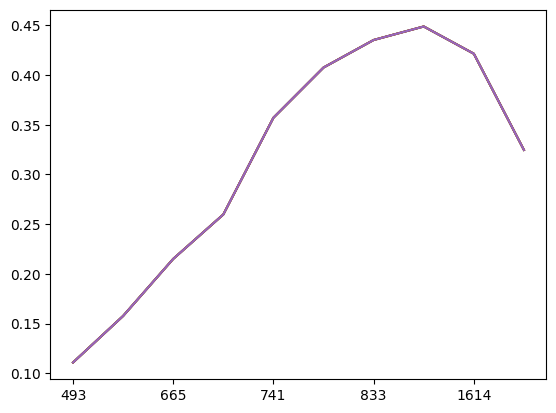

In [12]:
for i in range (0,5,1):
    spectra.iloc[i,:].plot()

In [13]:
# def cr_in_loop(X):
#     num_chunks = 10
#     chunk_size = int(X.shape[0] / num_chunks)
#     cr_X = X.copy()
    
#     for i in range(0, X.shape[0], chunk_size):
#         end_idx = min(i + chunk_size, X.shape[0])
#         print('cr running for chunk', i, 'to', end_idx)
#         cr_X.iloc[i:end_idx, :] = continuum_removed_fast(X.iloc[i:end_idx])
    
#     return cr_X

In [14]:
with open ('cr_spec.pickle', 'rb') as file:
    cr_spec = pickle.load(file)

In [15]:
#cr_spec = continuum_removed_fast (spectra.copy())

In [16]:
#cr_spec = cr_spec.astype('float32')

In [17]:
# with open ('cr_spec.pickle', 'wb') as file:
#     pickle.dump(cr_spec, file)

In [18]:
# with open ('spectra.pickle', 'wb') as file:
#     pickle.dump(spectra, file)

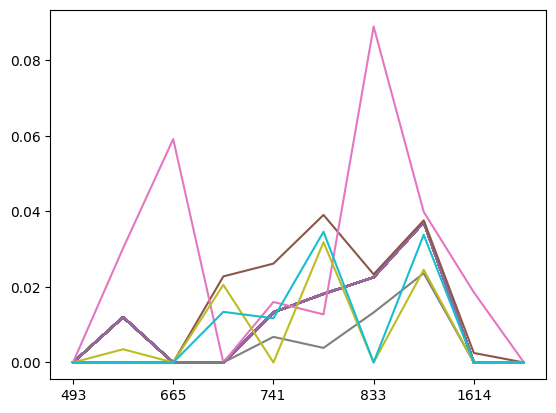

In [19]:
for i in range (6000,6100,1):
    cr_spec.iloc[i,:].plot()

In [20]:
print('log started..')
log_spec = ((1/spectra.copy()).apply(np.log)).copy()
print('.... complete')

print('fod started..')
fod_spec = fod(spectra.copy())
print('.... complete')

print('fod_cr started..')
fod_cr_spec = fod (cr_spec.copy())
print('.... complete')

print('fod_log started..')
fod_log_spec = fod (log_spec.copy())
print('.... complete')

log started..
.... complete
fod started..
.... complete
fod_cr started..
.... complete
fod_log started..
.... complete


In [21]:
log_spec.replace([np.inf, -np.inf], np.nan, inplace=True)
log_spec = log_spec.ffill().bfill()

fod_spec.replace([np.inf, -np.inf], np.nan, inplace=True)
fod_spec = fod_spec.ffill().bfill()

fod_log_spec.replace([np.inf, -np.inf], np.nan, inplace=True)
fod_log_spec = fod_log_spec.ffill().bfill()

fod_cr_spec.replace([np.inf, -np.inf], np.nan, inplace=True)
fod_cr_spec = fod_cr_spec.ffill().bfill()

spectra.replace([np.inf, -np.inf], np.nan, inplace=True)
spectra = spectra.ffill().bfill()

cr_spec.replace([np.inf, -np.inf], np.nan, inplace=True)
cr_spec = cr_spec.ffill().bfill()

In [22]:
log_spec.max()

493     7.013116
560     4.866535
665     9.210340
704     7.600903
741     6.907755
783     7.957578
833     9.903487
865     8.517193
1614    4.779524
2202    4.465408
dtype: float32

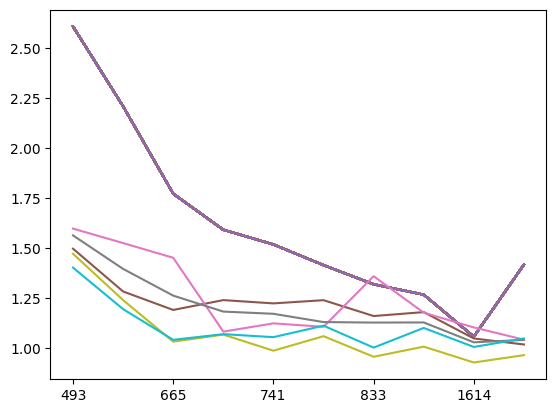

In [23]:
for i in range (6000,6100,1):
    log_spec.iloc[i,:].plot()

In [24]:

# Function to get appropriate model based on soil property
def get_model_dump(soil_property):
    if soil_property == 'caco3':
        return './models/CaCO3_model_cubist.pkl'
    elif soil_property == 'clay':
        return './models/clay_model_plsr.pkl'
    elif soil_property == 'toc':
        return './models/TOC_model_gbrt.pkl'
    elif soil_property == 'silt':
        return './models/silt_model_gbrt.pkl'
    elif soil_property == 'sand':
        return './models/sand_model_cubist.pkl'

def get_spectra(soil_property):
    if soil_property == 'caco3':
        spec = fod_spec.copy()
    elif soil_property == 'clay':
        spec = log_spec.copy()
    elif soil_property == 'toc':
        spec = cr_spec.copy()
    elif soil_property == 'silt':
       spec = fod_spec.copy()
    elif soil_property == 'sand':
       spec = fod_log_spec.copy()
    return spec.astype(float)    

# Function to predict soil property using pre-trained model
def predict_soil_property(soil_property):
    dumpName = get_model_dump(soil_property)
    model = pickle.load(open(dumpName, 'rb'))
    print(f'Model loaded for {soil_property}')
    x_pred = get_spectra(soil_property)    
    return model.predict(x_pred)

In [ ]:
sand_prediction = predict_soil_property('sand')

y_pred_sand = sand_prediction.copy()

y_pred_sand_df = pd.DataFrame(y_pred_sand)
y_pred_sand_df[bool_nan_rows] = np.nan
y_pred_sand= y_pred_sand_df.to_numpy()

predicted_sand = y_pred_sand.reshape(height, width)

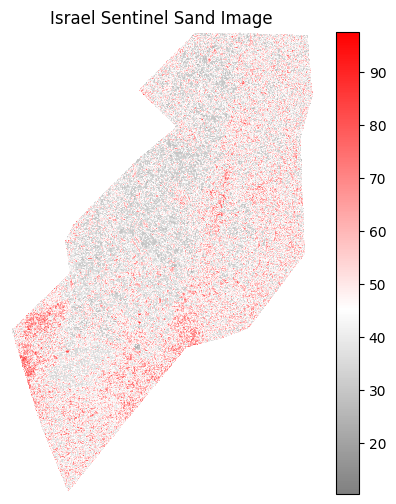

In [97]:
from matplotlib.colors import LinearSegmentedColormap
plt.figure(figsize=(6, 6))  # Adjust figure size as needed

# Define a custom colormap
colors = [(0, 'gray'),(0.4, 'white'), (1, 'red')]
custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', colors)

plt.imshow(predicted_sand, cmap = custom_cmap)

plt.colorbar()  # Optional: Display color bar to show intensity scale
plt.title('Israel Sentinel Sand Image')  # Optional: Add a title
plt.axis('off')  # Optional: Hide axis values
plt.show()

In [43]:
silt_prediction = predict_soil_property('silt')

y_pred_silt = silt_prediction.copy()

y_pred_silt_df = pd.DataFrame(y_pred_silt)
y_pred_silt_df[bool_nan_rows] = np.nan
y_pred_silt = y_pred_silt_df.to_numpy()

predicted_silt = y_pred_silt.reshape(height, width)

Model loaded for silt


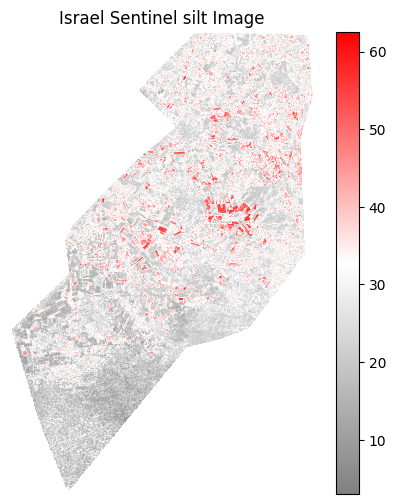

In [98]:
from matplotlib.colors import LinearSegmentedColormap
plt.figure(figsize=(6, 6))  # Adjust figure size as needed

# Define a custom colormap
colors = [(0, 'gray'),(0.5, 'white'), (1, 'red')]
custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', colors)

plt.imshow(predicted_silt, cmap = custom_cmap)

plt.colorbar()  # Optional: Display color bar to show intensity scale
plt.title('Israel Sentinel silt Image')  # Optional: Add a title
plt.axis('off')  # Optional: Hide axis values
plt.show()

In [45]:
clay_prediction = predict_soil_property('clay')

y_pred_clay = clay_prediction.copy()

y_pred_clay_df = pd.DataFrame(y_pred_clay)
y_pred_clay_df[bool_nan_rows] = np.nan
y_pred_clay = y_pred_clay_df.to_numpy()

predicted_clay = y_pred_clay.reshape(height, width)

Model loaded for clay


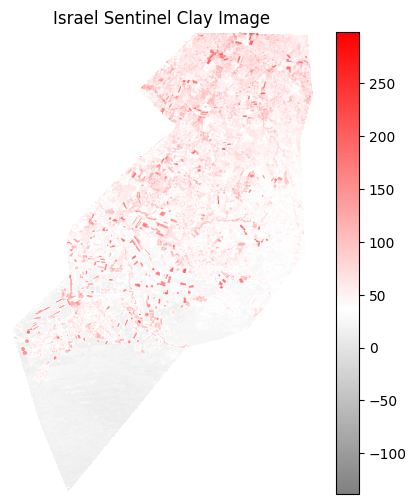

In [105]:
from matplotlib.colors import LinearSegmentedColormap
plt.figure(figsize=(6, 6))  # Adjust figure size as needed

# Define a custom colormap
colors = [(0, 'gray'),(0.4, 'white'), (1, 'red')]
custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', colors)

plt.imshow(predicted_clay, cmap = custom_cmap)

plt.colorbar()  # Optional: Display color bar to show intensity scale
plt.title('Israel Sentinel Clay Image')  # Optional: Add a title
plt.axis('off')  # Optional: Hide axis values
plt.show()

In [47]:
toc_prediction = predict_soil_property('toc')

y_pred_toc = toc_prediction.copy()

y_pred_toc_df = pd.DataFrame(y_pred_toc)
y_pred_toc_df[bool_nan_rows] = np.nan
y_pred_toc = y_pred_toc_df.to_numpy()

predicted_toc = y_pred_toc.reshape(height, width)

Model loaded for toc


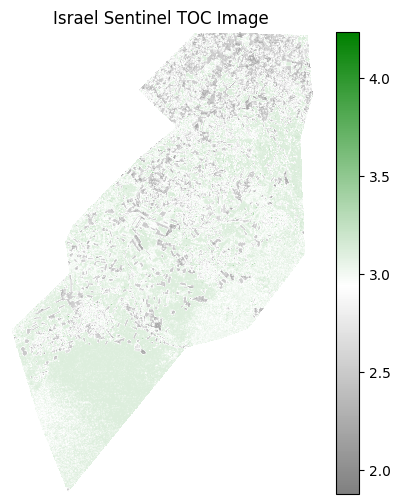

In [111]:
from matplotlib.colors import LinearSegmentedColormap
plt.figure(figsize=(6, 6))  # Adjust figure size as needed

# Define a custom colormap
colors = [(0, 'gray'),(0.45, 'white'), (1, 'green')]
custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', colors)

plt.imshow(predicted_toc, cmap = custom_cmap)

plt.colorbar()  # Optional: Display color bar to show intensity scale
plt.title('Israel Sentinel TOC Image')  # Optional: Add a title
plt.axis('off')  # Optional: Hide axis values
plt.show()

In [64]:
caco3_prediction = predict_soil_property('caco3')

y_pred_caco3 = caco3_prediction.copy()

y_pred_caco3_df = pd.DataFrame(y_pred_caco3)
y_pred_caco3_df[bool_nan_rows] = np.nan
y_pred_caco3 = y_pred_caco3_df.to_numpy()

predicted_caco3 = y_pred_caco3.reshape(height, width)

Model loaded for caco3


C:\Users\abhis\AppData\Local\Programs\Python\Python311\Lib\site-packages\cubist\_make_data_string.py:67: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  x = x.applymap(lambda a: a.lstrip())


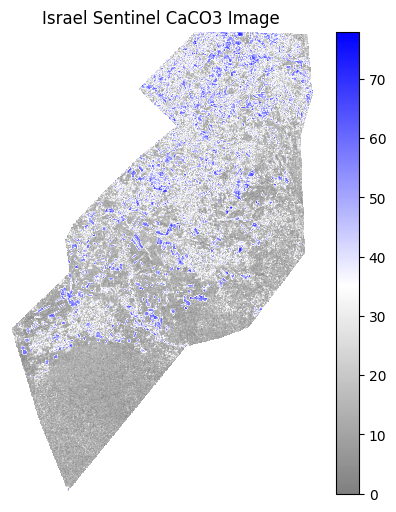

In [115]:
from matplotlib.colors import LinearSegmentedColormap
plt.figure(figsize=(6, 6))  # Adjust figure size as needed

# Define a custom colormap
colors = [(0, 'gray'),(0.45, 'white'), (1, 'blue')]
custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', colors)

plt.imshow(predicted_caco3, cmap = custom_cmap)

plt.colorbar()  # Optional: Display color bar to show intensity scale
plt.title('Israel Sentinel CaCO3 Image')  # Optional: Add a title
plt.axis('off')  # Optional: Hide axis values
plt.show()